In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
random.seed(1234)

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import PrecisionRecallDisplay

In [2]:
data=pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382387 entries, 0 to 382386
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            382387 non-null  int64  
 1   type            382387 non-null  object 
 2   amount          382387 non-null  float64
 3   nameOrig        382387 non-null  object 
 4   oldbalanceOrg   382387 non-null  float64
 5   newbalanceOrig  382387 non-null  float64
 6   nameDest        382387 non-null  object 
 7   oldbalanceDest  382387 non-null  float64
 8   newbalanceDest  382387 non-null  float64
 9   isFraud         382387 non-null  int64  
 10  isFlaggedFraud  382387 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 32.1+ MB


In [5]:
#checking null values
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [6]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,382387.000000,3.823870e+05,3.823870e+05,3.823870e+05,3.823870e+05,3.823870e+05,382387.000000,382387.0
mean,12.498095,1.736030e+05,9.094287e+05,9.289494e+05,9.844741e+05,1.185390e+06,0.000533,0.0
std,3.100165,2.885811e+05,2.974605e+06,3.011779e+06,2.358384e+06,2.558127e+06,0.023091,0.0
min,1.000000,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,10.000000,1.339042e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,13.000000,8.136435e+04,1.819829e+04,0.000000e+00,1.041061e+05,2.130456e+05,0.000000,0.0
75%,15.000000,2.310122e+05,1.769772e+05,2.177631e+05,8.825978e+05,1.227906e+06,0.000000,0.0
max,17.000000,1.000000e+07,3.893942e+07,3.894623e+07,4.138365e+07,4.148270e+07,1.000000,0.0


In [7]:
#distribution of fraud transaction
data['isFraud'].value_counts()

,count
isFraud,
0,382183
1,204


**EDA**

Note: Notice how imbalanced our original dataset is. Most of the transaction are not fraud. So, if we use this dataframe as the base for our predictive models and analysis our model might overfit since it will assume all the transactions are not fraud.

Text(0.5, 1.0, 'Class Distributions')

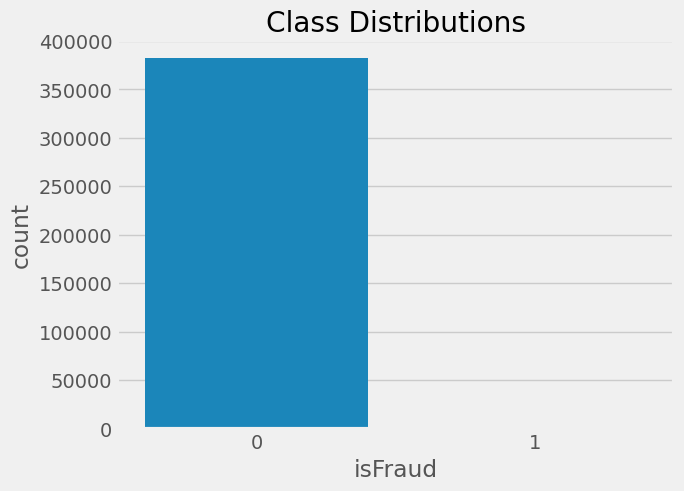

In [8]:
sns.countplot(data=data,x='isFraud')
plt.title('Class Distributions')

Since, the step column represnts the number of hours elapsed, we can create time-based features such as data of the week, hour of the day or even binary feature that indicates whether the transaction occured during the business hours or not.

Text(0.5, 1.0, 'Distribution of type of transactions')

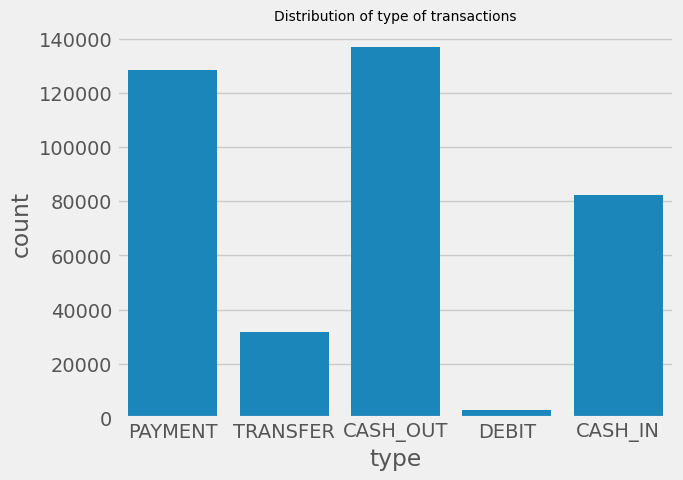

In [9]:
#lets check the type of transactions
sns.countplot(data=data,x='type')
plt.title('Distribution of type of transactions',fontsize=10)

In [10]:
#creating a columns having time stemp of 24hr
data['hourOfDay']=data['step']%24

There are two flags:

**isFraud**: indicates the actual fraud transactions

**isFlaggedFraud** : System prevent the transaction when an attempt to transfer more than 200.000 in a single transaction made

Lets check the kinds of transactions are being falgged and are fraud

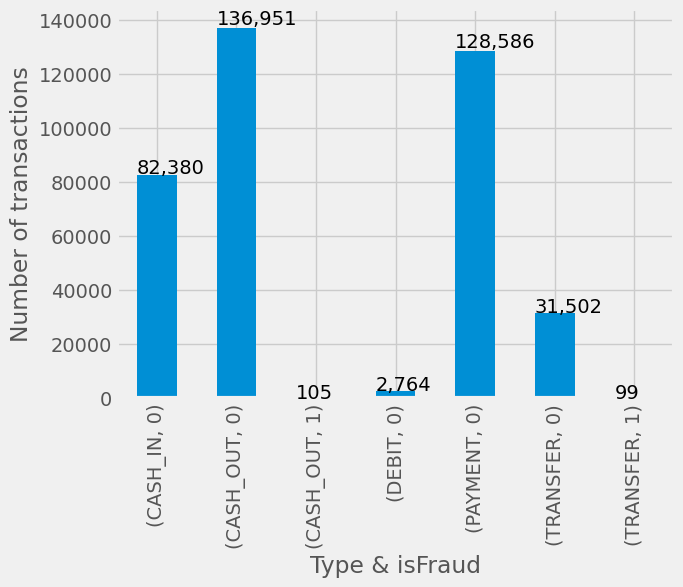

In [11]:
ax=data.groupby(['type','isFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

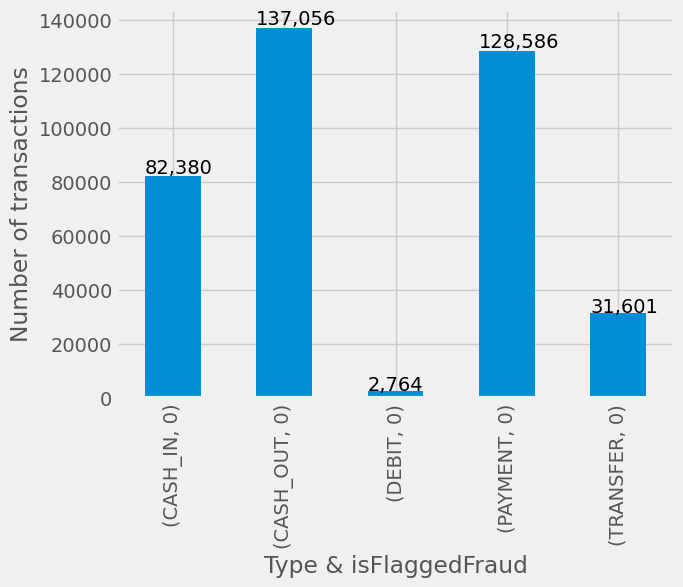

In [12]:
ax=data.groupby(['type','isFlaggedFraud']).size().plot(kind='bar')
ax.set_title('')
ax.set_xlabel("Type & isFlaggedFraud")
ax.set_ylabel("Number of transactions")
for t in ax.patches:
    ax.annotate(str(format(int(t.get_height()),',d')),(t.get_x(),t.get_height()*1.01))

Note: System has flag 16 transfer transactions as fraud.

In [13]:
#lets analyse the fraud on different time stamp of the day
fraud_df=data[data['isFraud']==1]

In [14]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hourOfDay
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,1
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,1
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,1


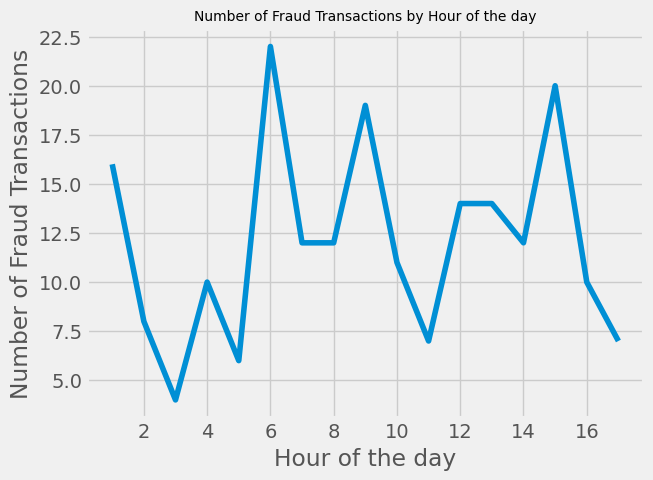

In [15]:
#plot showing the fraud wrt hour of the day
hourly_fraud_count=fraud_df.groupby('hourOfDay').size()
plt.plot(hourly_fraud_count.index,hourly_fraud_count.values)
plt.title('Number of Fraud Transactions by Hour of the day',fontsize=10)
plt.xlabel('Hour of the day')
plt.ylabel('Number of Fraud Transactions')
plt.show()

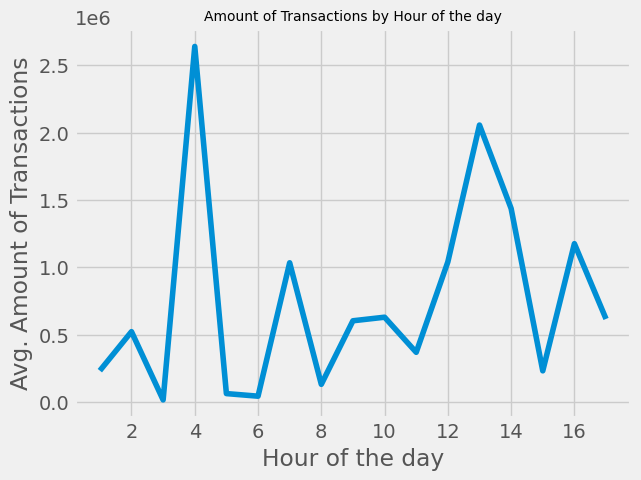

In [16]:
#lets check the amount of transaction took place in different time stamp
hourly_transaction=fraud_df.groupby('hourOfDay')['amount'].mean()
plt.plot(hourly_transaction.index,hourly_transaction.values)
plt.title('Amount of Transactions by Hour of the day',fontsize=10)
plt.xlabel('Hour of the day')
plt.ylabel('Avg. Amount of Transactions')
plt.show()

In [17]:
#lets check the type of transactions took place in Fraud transactions
fraud_df['type'].unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

<Axes: xlabel='type', ylabel='count'>

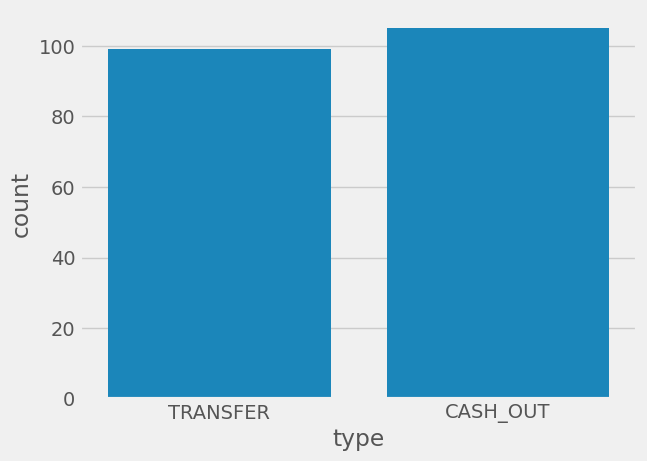

In [18]:
sns.countplot(data=fraud_df,x='type')

Note: The distributions are skewed

(1.0, 17.0)

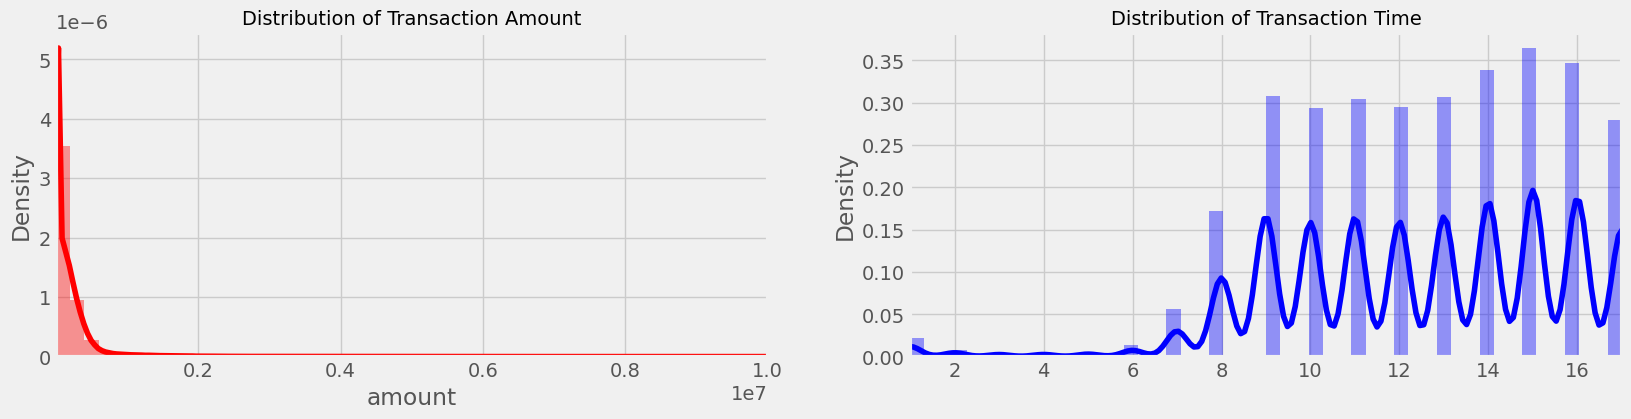

In [19]:
#lets check the distribution of transaction amount and transaction time
fig,ax=plt.subplots(1,2,figsize=(18,4))
amount_val=data['amount']
time_val=data['hourOfDay'].values

sns.distplot(amount_val,ax=ax[0],color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

When the fraud is made, who is the recepent?

In [20]:
print("Number of fraud transactions where the recipient is Marchent",fraud_df[fraud_df.nameDest.str.contains('M')].shape[0])
print("Number of fraud transactions where the giver is Marchent",fraud_df[fraud_df.nameOrig.str.contains('M')].shape[0])

Number of fraud transactions where the recipient is Marchent 0
Number of fraud transactions where the giver is Marchent 0


**Observation:** When the fradulent transation made there were no involvement of Marchent on either side

As per the information, the transactions are flagged fraud only when the amount is more than 200,000.But we can observe that the when the transaction is not flagged fraud transaction of more than 200,000 has been made.

In [21]:
df_transfer_f=data[(data['type']=='TRANSFER')&(data['isFlaggedFraud']==1)]
print("Min and Max transactions when the transaction is flagged fraud",(df_transfer_f['amount'].min(),df_transfer_f['amount'].max()))
df_transfer_nf=data[(data['type']=='TRANSFER')&(data['isFlaggedFraud']==0)]
print("Min and Max transactions when the transaction is not flagged fraud",(df_transfer_nf['amount'].min(),df_transfer_nf['amount'].max()))

Min and Max transactions when the transaction is flagged fraud (nan, nan)
Min and Max transactions when the transaction is not flagged fraud (46.22, 10000000.0)


**observation:** The transactions which are flagged fraud have same old and new balance in both destination and origin account. But there are 4158 transactions where it has not been flagged fraud and the old and new balance is 0.

In [22]:
df_transfer_nf[(df_transfer_nf['oldbalanceDest']==0)&(df_transfer_nf['newbalanceDest']==0)].shape[0]

138

**Feature Engineering¶**

In imbalanced datasets, where the number of negative instances is much higher than the number of positive instances, a model may predict mostly negative instances to achieve high accuracy. However, this can result in low recall, as the model may miss some important positive instances.

In [23]:
# fraud transaction occur only in'TRANSFER' and 'CASH_OUT', So, we are going to consider these only
X=data.loc[(data.type=='TRANSFER')|(data.type=='CASH_OUT')]
y=X['isFraud']

In [24]:
y.value_counts()

,count
isFraud,
0,168453
1,204


In [25]:
#Mapping type of transfer
X['type']=X['type'].map({'TRANSFER':0,'CASH_OUT':1})

In [26]:
#number of transactions where the new balance is 0
X[(X['newbalanceOrig']==0)&(X['newbalanceDest']==0)].shape

(4529, 12)

Note: In 49.5% of fraud transaction when the amount of more than 0 has been transfer the new and oldbalanceDest remain 0. Whereas in only 0.06% non-fraud transactions the balance has remain 0

In [27]:
#the number of fraud transactions where after transfering amount more than 1 the banlance is 0
(X[(X['newbalanceDest']==0)&(X['oldbalanceDest']==0)&(X['isFraud']==1)&(X['amount']>0)].shape[0])/(X[X['isFraud']==1].shape[0])

0.4068627450980392

In [28]:
(X[(X['newbalanceDest']==0)&(X['oldbalanceDest']==0)&(X['isFraud']==0)&(X['amount']>0)].shape[0])/(X[X['isFraud']==0].shape[0])

0.0037636610805387855

Hence, the destination account balance is highly correlated with the fraud transaction. The destination account is often 0 when fraud occur So, if algorithm were to estimate before the transaction occur it can mark transaction as fraud and make it more difficult to detect fraudulent transactions. So we can repalce 0 with -1 where the balance is 0.

In [29]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0),['oldbalanceDest', 'newbalanceDest']] =-1

The data have many transaction where the original balance is 0 and the amount transaction is more than 0, So replacing 0 with nan

In [30]:
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0),['oldbalanceOrg', 'newbalanceOrig']] = np.nan


In [31]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hourOfDay
2,1,0,181.00,C1305486145,181.0,0.0,C553264065,-1.0,-1.00,1,0,1
3,1,1,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,1
15,1,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1
19,1,0,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1
24,1,0,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


In [32]:
X['orgBalanceError']=X['newbalanceOrig']+X['amount']-X['oldbalanceOrg']
X['destBalanceError']=X['newbalanceDest']+X['amount']-X['oldbalanceDest']

In [34]:
#droping nameOrig,'nameDest' and 'isFlaggedFraud' as these found to be irrelevent in EDA
X=X.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud','isFraud'])

In [35]:
X.isnull().sum()

,0
step,0
type,0
amount,0
oldbalanceOrg,80782
newbalanceOrig,80782
oldbalanceDest,0
newbalanceDest,0
hourOfDay,0
orgBalanceError,80782
destBalanceError,0


In [36]:
#replacing the nan value with the median of the non fraud column
X=X.fillna(X.median())

In [37]:
X.isnull().sum()

,0
step,0
type,0
amount,0
oldbalanceOrg,0
newbalanceOrig,0
oldbalanceDest,0
newbalanceDest,0
hourOfDay,0
orgBalanceError,0
destBalanceError,0


**Spliting data**

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [39]:
#SMOTE on the training data
smote=SMOTE(random_state=42)
X_train_re,y_train_re=smote.fit_resample(X_train,y_train)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [42]:
def model_fit(model,X_train,X_test,y_train,y_test):
    clf_pipe=Pipeline([('clf',model)])
    clf=clf_pipe.fit(X_train,y_train)
    y_pred=clf_pipe.predict(X_test)
    return y_pred

In [43]:
clf=XGBClassifier(max_depth=3, n_jobs=4)
y_pred=model_fit(clf,X_train_re,X_test,y_train_re,y_test)

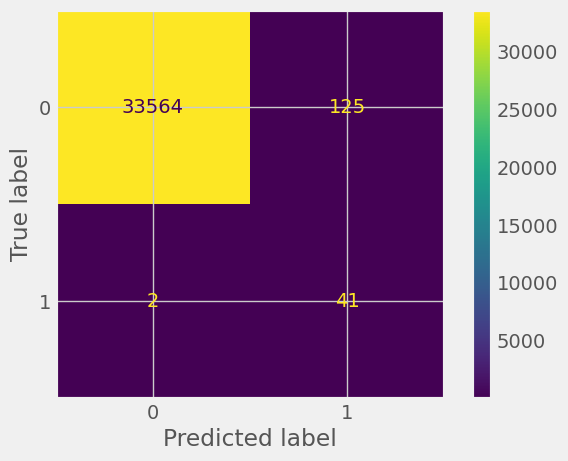

In [44]:
#xgboost confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [45]:
f1_score(y_test,y_pred)

0.3923444976076555

In [46]:
average_precision_score(y_test,y_pred)

0.23555943097632726

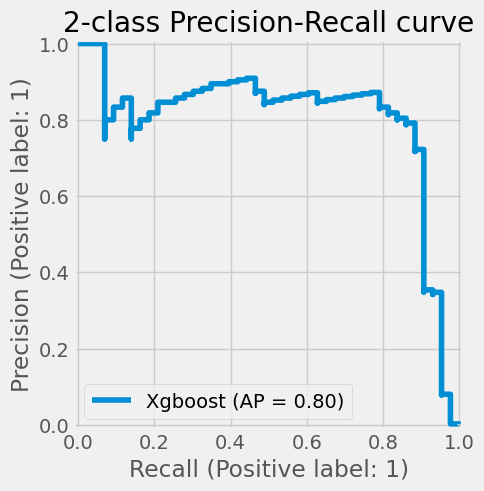

In [47]:
#xgboost AUCROC
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="Xgboost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [48]:
#random forest
clf=RandomForestClassifier()
y_pred=model_fit(clf,X_train_re,X_test,y_train_re,y_test)

In [49]:
f1_score(y_test,y_pred)

0.8118811881188119

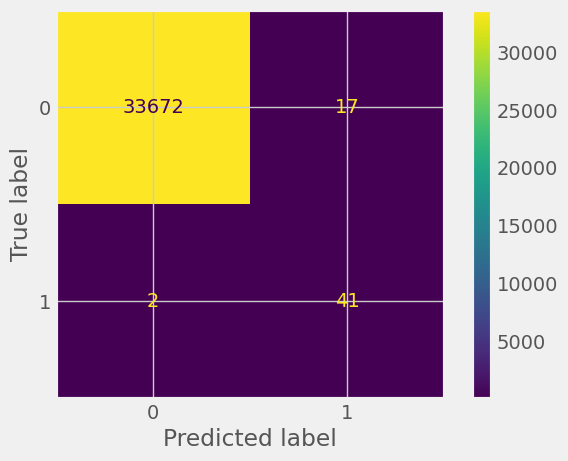

In [50]:
#randomforest confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

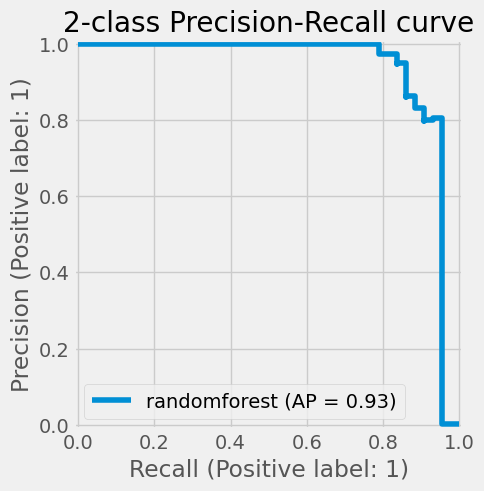

In [51]:
#randomforest AUCROC
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="randomforest")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [52]:
clf=ExtraTreesClassifier()
y_pred=model_fit(clf,X_train_re,X_test,y_train_re,y_test)

In [53]:
f1_score(y_test,y_pred)

0.5769230769230769

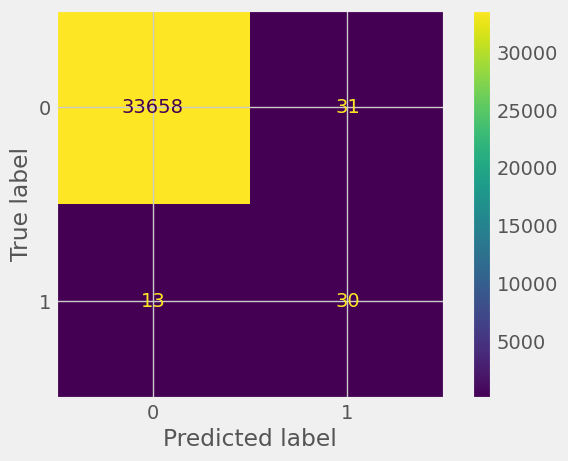

In [54]:
#extratree confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

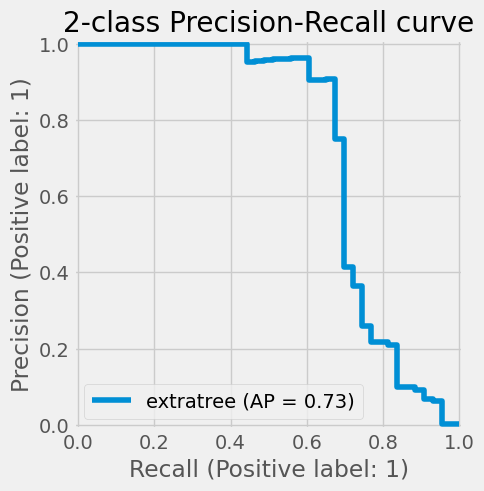

In [55]:
#extratree AUCROC
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="extratree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

**Conclusion**

RandomforestClassfier performed the best with the F1 score of 0.81 with least False positive classification. As a fraud detection model we do not want the non-fraudulent transactions to be consider as the fraud this may cause inconvenience to the end user.

Demonstrate the performance of the model by using best set of tools.

1)We do not want high FPR i.e., considering non-fraulent cases as fraud.

In the case of fraud detection, it is generally desirable to minimize false negatives (i.e., classifying a fraudulent transaction as non-fraudulent), as this can result in financial losses and damage to the reputation of the business. Therefore, a high recall (i.e., low false negative rate) may be more important than precision (i.e., low false positive rate). However, it is also important to balance the trade-off between recall and precision, as high recall can come at the cost of low precision, which may lead to unnecessary investigations and false accusations

 2)What are the key factors that predict fraudulent customer?
The difference in the balance before and after the transaction palyed a huge role in identifying the fraud detection. As for the some cases there were no update in the balance after the trasactions.

3) Do these factors make sense? If yes, How? If not, How not?
Yes, In normal transactions, there is typically a change in the balance of an account after a transaction occurs. For example, if a person makes a purchase using their credit card, the balance on their credit card account will decrease by the amount of the purchase.

In such cases, the lack of expected change in the balance after a transaction can be a red flag for fraud detection systems, which may trigger an investigation into the transaction to determine if it is legitimate or not.

4) What kind of prevention should be adopted while company update its infrastructure?
Testing and Validation: The updated infrastructure and the new fraud detection model should be thoroughly tested and validated before being deployed in the production environment. This helps to ensure that the system is working as expected and is effective in detecting fraud.

Monitoring and Reporting: The company should implement a system for monitoring and reporting on the performance of the fraud detection model. This helps to identify any issues or anomalies in the system and allows for timely intervention.

Continuous Improvement: Fraudsters are constantly evolving their techniques, so the company should continuously improve the fraud detection model to keep up with these changes. This can be done through regular updates, feedback from users, and incorporating new technologies and techniques.

By adopting these prevention measures, a company can ensure the security and effectiveness of its fraud detection model and minimize the risk of financial loss due to fraudulent activities.

 5)suming these actions have been implemented, how would you determine if they work?
To determine if the prevention measures adopted during the update of infrastructure for a fraud detection model are effective, several metrics can be used to measure the performance of the system. These metrics include:

False Positive Rate: The false positive rate measures the number of legitimate transactions that are flagged as fraudulent. A high false positive rate can result in increased operational costs and customer dissatisfaction.

False Negative Rate: The false negative rate measures the number of fraudulent transactions that are not detected by the system. A high false negative rate can result in financial losses due to fraudulent activities.

Detection Time: The detection time measures the time taken by the system to detect fraudulent transactions. A shorter detection time indicates a more effective system.

Accuracy: The accuracy measures the overall performance of the system in detecting fraudulent transactions. It is calculated as the number of correctly identified fraudulent transactions divided by the total number of transactions.

Return on Investment (ROI): The ROI measures the financial benefits of the fraud detection system compared to the costs of implementing and maintaining it. It is calculated as the net benefit of the system divided by the cost of the system.

By monitoring these metrics over time and comparing them to industry benchmarks and historical data, the company can determine if the prevention measures adopted during the update of infrastructure for a fraud detection model are effective. Regular performance evaluations and updates to the system will help to ensure that it continues to perform at an optimal level